# Script to run the SSD simulations
This script starts the SSD simulations. It is possible to change the input parameters and select the areas to be simulated more precisely. 

In [569]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import time
import requests
import seaborn as sns
from sqlalchemy import create_engine  # For database connection
from config import db_username, db_password, db_host, db_port, db_name # Database credentials

import plotly.express as px
from shapely import wkb
import geopandas as gpd               # For geospatial data processing

# Suppress warnings for better readability of the output
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import geopandas as gpd
from shapely import wkb, wkt
from shapely.geometry.base import BaseGeometry

In [570]:
# Create connection string
connection_string = f'postgresql://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}'
# Create SQLAlchemy engine
engine = create_engine(connection_string)

In [571]:
# SQL query to number of businesses (by borough) for testing Ville-Marie NUM 20
query_boroughs = """
        SELECT * FROM public.boroughs;
"""
# Executing the query for buisnesses calculation and storing the result in a DataFrame
boroughs = pd.read_sql(query_boroughs, engine)
# Display the population density data
boroughs.to_excel('boroughs.xlsx', index=False)
boroughs.head(3)

,CODEID,NOM,NOM_OFFICI,CODEMAMH,CODE_3C,NUM,ABREV,TYPE,COMMENT,DATEMODIF,geometry
0,0,Montreal island,Montreal island,MIS,MIS,0,MI,City,produced and named by Reiner Braun,2025-03-27,0103000020E6100000010000004D070000C3EFB490F275...
1,10,LaSalle,None,REM17,None,18,LS,Arrondissement,None,2023-11-29,0103000020E610000001000000880200004F48F772A16A...
2,3,Dollard-des-Ormeaux,None,66142,None,11,DO,Ville liée,None,2023-11-29,0103000020E610000001000000FB020000597EC4E72D76...


In [572]:
# String1 = 'https://restapi.frankfurtskreative.de'
String1 = 'http://192.168.178.24:5000'

### Read the scenarios defined in the scenarios file

In [573]:
response = requests.get(String1 + '/scenarios')

In [574]:
response.json()

{'food_security': ['food_stores', 'interactive_scenario', 'base']}

In [575]:
response = requests.post(
    url=f'{String1}/equations',
    json = {
    "scenarioManager": "food_security",
    "scenario":"base"
}
)

In [576]:
# Show the constants, converters, flows and stocks in the model. All the parameters you can see here can be queried.
parameters = response.json()
# parameters

In [577]:
# Combine converters and stocks into one equations list
equations_list = parameters['converters'] + parameters['stocks']
print(equations_list)

['initialNonImmigrants', 'newBuildRateOfPublicTransportStations', 'accessibilityOfHealthyFoodInLocalArea', 'insufficientFoodBudget', 'publicTransportStationDevelopment', 'cTwoParent', 'initialNumberOfHealthyFoodStore', 'needToShopOutsideLocality', 'residentialOrGeographicalSegregation', 'cSingleParent', 'initialPrivateRentalMarket', 'strategicUnhealthyEatingHabits', 'initialSinglePersonLivingAlone', 'financialManagement', 'shelterFlow', 'initialMultigenerational', 'cNonPermanentResidents', 'newBuildRateAutomaticVendingMachines', 'negativePerceptionsOfLocalArea', 'newBuildRateSupermarketAndHealthyFoodStore', 'initialTotalPrivateRentalMarket', 'accessibilityAndAffordabilityOfPublicTransport', 'livingCostBurden', 'initialNumberOfUrbanFarms', 'initialTwoParent', 'cCoupleWithoutChildren', 'initialImmigrants', 'supermarketAndHealthyFoodStoreDensity', 'initialNonPermanentResidents', 'optimalProductionDensity', 'vulnerabilityToFluctuationInLivingCosts', 'customerDemandForHealthyFood', 'publicT

In [578]:
# List of NUM values to loop over
# NUM_list = [0]

# Senneville
# NUM_list = [77]

# NUM_list = [16, 8, 20]
NUM_list = [7, 20, 16]
# NUM_list =[0, 24, 9, 71, 76, 72, 27, 11, 1, 10, 6, 3, 17, 14, 15, 18, 23, 16, 2, 5, 8, 22, 13, 25, 19, 21, 12, 20, 26, 4]
# NUM_list = [24, 9, 7, 71, 76, 72, 27, 11, 1, 10, 6, 3, 17, 14, 15, 18, 74, 23, 16, 75, 2, 5, 8, 22, 13, 25, 19, 21, 77, 12, 20, 26, 4] #73,
# NUM_list = [2, 4, 24, 9, 72, 27, 11, 1, 6, 17, 14, 15, 18, 23, 16, 5, 8, 22, 13, 25, 19, 21, 12, 20, 26, 3, 7] #74, 73, 76, 77, 71, 10, 75

# Random selected
# NUM_list = [9, 72, 27, 11, 4, 8, 20] 

# NUM_list = [24, 9, 72, 27, 1, 18, 17, 22, 21, 23, 11, 2, 16, 5, 13, 8, 19, 25, 15, 14, 12, 20, 26, 4] #74, 
# NUM_list = [101, 102, 103] #74, 

results = []

for NUM in NUM_list:
    # POST request to write the scenario with the current NUM    
    # Initial run
    # res = requests.post(
    #     url=f'{String1}/write_scenario',
    #     json=f'{{"city": "Montreal", "borough_name": "Ville-Marie", "NUM": {NUM}, \
    #     "newBuildRateSupermarketAndHealthyFoodStore": 0.112, \
    #     "newBuildRateFastFoodOutlet": -0.0179, \
    #     "newBuildRatePublicTransport": 0.001, \
    #     "newBuildRateUrbanFarmsCg": 0.0, \
    #     "optimalPublicTransportStationDensity": 8, \
    #     "optimalProductionDensity": 8, \
    #     "negativePerceptionsOfLocalArea": 0.5, \
    #     "residentialOrGeographicalSegregation": 0.5, \
    #     "costsPublicTransportUse": 0.47, \
    #     "costsIndividualVehicleUse": 0.72, \
    #     "openingHoursOfSupermarketsDailyStores": 0.5, \
    #     "reductionInShelterCosts": 0.0}}'
    # )
    
    # Minimizeing food insecurity
    # res = requests.post(
    #     url=f'{String1}/write_scenario',
    #     json=f'{{"city": "Montreal", "borough_name": "Ville-Marie", "NUM": {NUM}, \
    #     "newBuildRateSupermarketAndHealthyFoodStore": 0.112, \
    #     "newBuildRateFastFoodOutlet": -0.215, \
    #     "newBuildRatePublicTransport": 0.001, \
    #     "newBuildRateUrbanFarmsCg": 0.1, \
    #     "optimalPublicTransportStationDensity": 8, \
    #     "optimalProductionDensity": 8, \
    #     "negativePerceptionsOfLocalArea": 0.5, \
    #     "residentialOrGeographicalSegregation": 0.5, \
    #     "costsPublicTransportUse": 0.47, \
    #     "costsIndividualVehicleUse": 0.72, \
    #     "openingHoursOfSupermarketsDailyStores": 1, \
    #     "reductionInShelterCosts": 0.037}}'
    # )

    # Maximizing food insecurity
    # res = requests.post(
    #     url=f'{String1}/write_scenario',
    #     json=f'{{"city": "Montreal", "borough_name": "Ville-Marie", "NUM": {NUM}, \
    #     "newBuildRateSupermarketAndHealthyFoodStore": 0.112, \
    #     "newBuildRateFastFoodOutlet": 0.215, \
    #     "newBuildRatePublicTransport": 0.001, \
    #     "newBuildRateUrbanFarmsCg": 0.0, \
    #     "optimalPublicTransportStationDensity": 8, \
    #     "optimalProductionDensity": 8, \
    #     "negativePerceptionsOfLocalArea": 0.5, \
    #     "residentialOrGeographicalSegregation": 0.5, \
    #     "costsPublicTransportUse": 0.47, \
    #     "costsIndividualVehicleUse": 0.72, \
    #     "openingHoursOfSupermarketsDailyStores": 0, \
    #     "reductionInShelterCosts": -0.010}}'
    # )
    

    # Strategy reducing fast food outlets
    res = requests.post(
        url=f'{String1}/write_scenario',
        json=f'{{"city": "Montreal", "borough_name": "Ville-Marie", "NUM": {NUM}, \
        "newBuildRateSupermarketAndHealthyFoodStore": 0.112, \
        "newBuildRateFastFoodOutlet": 0.179, \
        "newBuildRatePublicTransport": 0.001, \
        "newBuildRateUrbanFarmsCg": 0.001, \
        "optimalPublicTransportStationDensity": 8, \
        "optimalProductionDensity": 8, \
        "negativePerceptionsOfLocalArea": 0.1, \
        "residentialOrGeographicalSegregation": 0.1, \
        "costsPublicTransportUse": 0.37, \
        "costsIndividualVehicleUse": 0.72, \
        "openingHoursOfSupermarketsDailyStores": 0.7, \
        "reductionInShelterCosts": 0.001}}'
    )

    
    # Pause for 1 second between requests
    time.sleep(1)
    
    # POST request to run the scenario, now using the equations from the parameters JSON
    response = requests.post(
        url=String1 + '/run',
        json={
            "scenario_managers": ["food_security"],
            "scenarios": ["base"],
            "equations": equations_list
        }
    )
    
    # Extract the equations results from the response
    data = response.json()['food_security']['base']['equations']
    
    # Build a result entry starting with the current NUM
    entry = {"NUM": NUM}
    # Loop over each equation in the combined list and add it to the entry
    for eq in equations_list:
        entry[eq] = data.get(eq)  # you can use .get() to safely retrieve the value
    
    results.append(entry)

# Create a DataFrame from the results list
df = pd.DataFrame(results)
# print(df)

In [579]:
results_geometry = pd.merge(df,boroughs,how='inner',on='NUM')
results_geometry.to_excel('simulation_runs.xlsx', index=False)
# results_geometry.head(5)

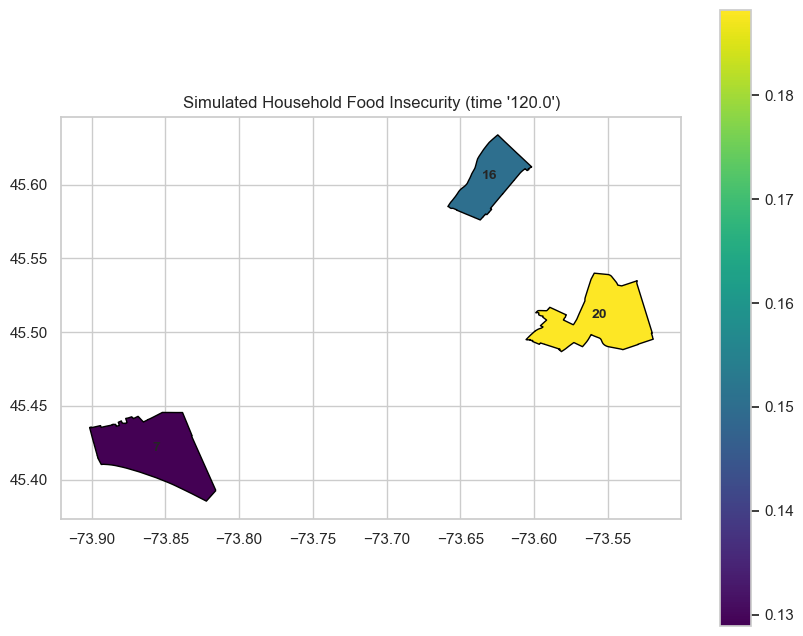

In [580]:
# Function to convert hex-encoded WKB to a shapely geometry object
def convert_wkb(hex_str):
    return wkb.loads(bytes.fromhex(hex_str))

# --- Assume df is your DataFrame as shown above ---
# 1. Convert the 'geometry' column from WKB hex to shapely geometries
results_geometry['geometry'] = results_geometry['geometry'].apply(convert_wkb)
# 2. Create a new column 'popGrowth' that extracts the value for time "0.0"
results_geometry['results'] = results_geometry['householdFoodInsecurity'].apply(lambda d: d.get('120.0') if isinstance(d, dict) else None)
# 3. Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(results_geometry, geometry='geometry')

# 4. Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='results', ax=ax, legend=True, cmap='viridis', edgecolor='black')

# 5. Annotate each feature with its NUM value at the centroid of its geometry
for idx, row in gdf.iterrows():
    # Compute the centroid coordinates
    centroid = row['geometry'].centroid
    ax.annotate(text=str(row['NUM']), xy=(centroid.x, centroid.y),
                horizontalalignment='center', fontsize=10, fontweight='bold')

plt.title("Simulated Household Food Insecurity (time '120.0')")

# Save the plot as a PNG file
plt.savefig('Figures/initialFoodInsecurity_map.png', dpi=300, bbox_inches='tight')
plt.show()

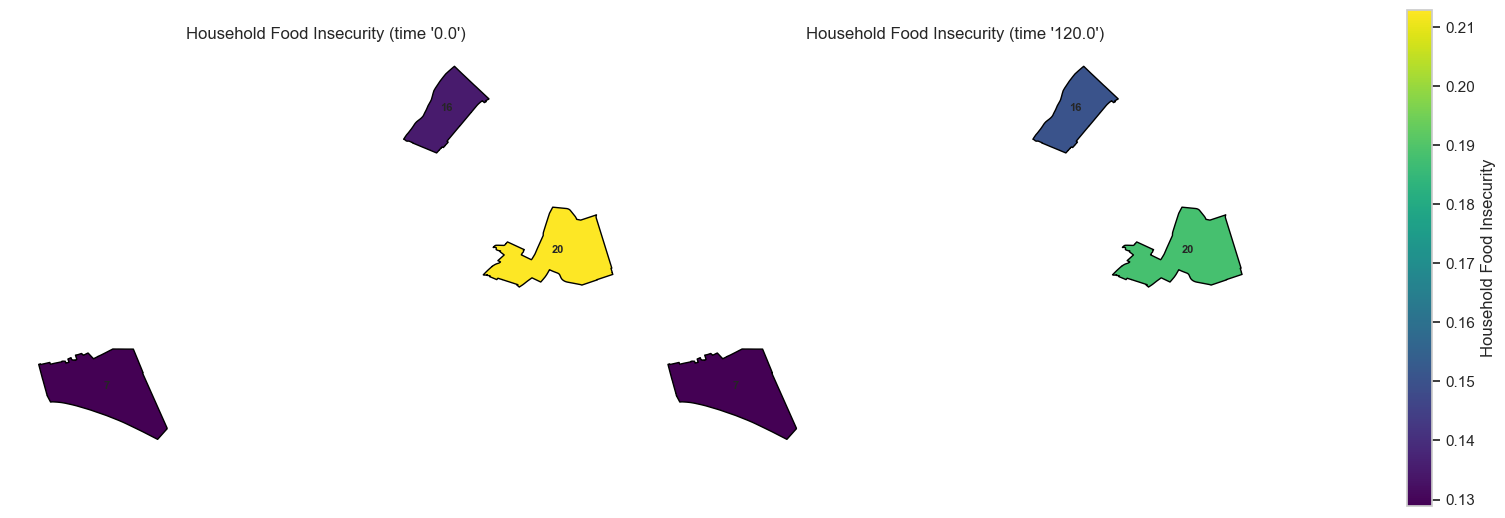

In [581]:
# --- Robust converter: handles Polygon, bytes WKB, and hex WKB (and WKT as fallback) ---
def to_geometry(val):
    if isinstance(val, BaseGeometry):
        return val
    if isinstance(val, (bytes, bytearray, memoryview)):
        return wkb.loads(bytes(val))
    if isinstance(val, str):
        s = val[2:] if val.startswith("0x") else val  # allow 0x-prefixed hex
        try:
            return wkb.loads(bytes.fromhex(s))
        except Exception:
            # maybe it's WKT
            try:
                return wkt.loads(val)
            except Exception:
                return None
    return None

# 1) Ensure geometry column is shapely
results_geometry['geometry'] = results_geometry['geometry'].apply(to_geometry)

# 2) Build GeoDataFrame
gdf = gpd.GeoDataFrame(results_geometry, geometry='geometry', crs=getattr(results_geometry, 'crs', None))

# 3) Extract both time steps
gdf['results_0'] = gdf['householdFoodInsecurity'].apply(lambda d: d.get('0.0') if isinstance(d, dict) else None)
gdf['results_120'] = gdf['householdFoodInsecurity'].apply(lambda d: d.get('120.0') if isinstance(d, dict) else None)

# 4) Shared color scale across both maps
vals = gdf[['results_0','results_120']].to_numpy(dtype=float)
vmin = np.nanmin(vals)
vmax = np.nanmax(vals)
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('viridis')

# 5) Plot side-by-side
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 10)   # enforce size here

gdf.plot(column='results_0', ax=axes[0], cmap=cmap, norm=norm, edgecolor='black')
axes[0].set_title("Household Food Insecurity (time '0.0')")
axes[0].axis('off')

gdf.plot(column='results_120', ax=axes[1], cmap=cmap, norm=norm, edgecolor='black')
axes[1].set_title("Household Food Insecurity (time '120.0')")
axes[1].axis('off')

# 6) Optional: annotate each polygon with NUM at centroid
for idx, row in gdf.iterrows():
    if row['geometry'] is not None and not row['geometry'].is_empty:
        c = row['geometry'].centroid
        for ax in axes:
            ax.annotate(text=str(row['NUM']), xy=(c.x, c.y), ha='center', fontsize=8, fontweight='bold')

# 7) Single, shared colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Place vertical colorbar at the far right
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), fraction=0.02, pad=-0.2, location='right')
cbar.set_label('Household Food Insecurity')
plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave room on the right
# plt.tight_layout()
plt.savefig('Figures/FoodInsecurity_0_vs_120.png', dpi=300, bbox_inches='tight')
# plt.savefig('Figures/FoodInsecurity_0_vs_120.png', dpi=300)
plt.show()


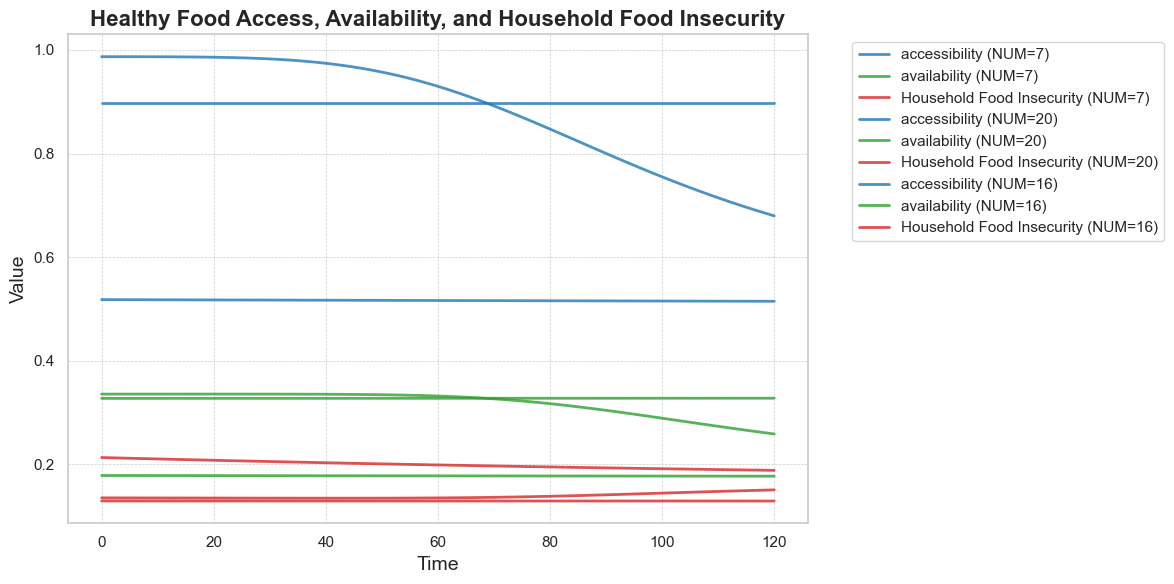

In [582]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Loop over each row (each NUM)
for idx, row in df.iterrows():
    NUM_val = row['NUM']
    
    # Define variable names and colors for consistent plotting
    variables = {
        'accessibilityOfHealthyFoodInLocalArea': 'tab:blue',
        'availabilityOfHealthyFoodInLocalArea': 'tab:green',
        'householdFoodInsecurity': 'tab:red'
    }
    
    for var_name, color in variables.items():
        # Convert each JSON-like column into a DataFrame
        df_var = pd.DataFrame.from_dict(
            pd.json_normalize(row[var_name]),
            orient='columns'
        ).T.reset_index(drop=True)

        plt.plot(
            df_var.index,
            df_var.values.flatten(),
            label=f'{var_name.replace("OfHealthyFoodInLocalArea", "").replace("householdFood", "Household Food ")} (NUM={NUM_val})',
            linestyle='-',
            linewidth=2,
            color=color,
            alpha=0.8
        )

# Set x-axis ticks (adjust if needed)
plt.xticks(ticks=range(0, len(df_var.index), 20))
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Healthy Food Access, Availability, and Household Food Insecurity', fontsize=16, weight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save and show
# plt.savefig('Figures/combined_food_metrics.png', dpi=300, bbox_inches='tight')
plt.savefig('Figures/combined_food_metrics.png', dpi=300)
plt.show()


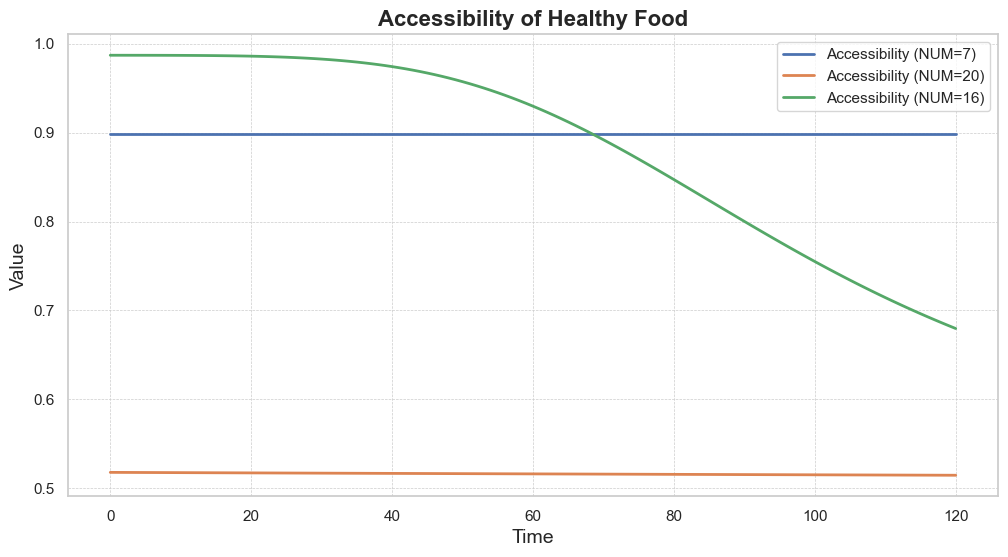

In [583]:
# Use seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Loop over each row in the DataFrame, where each row corresponds to a different NUM
for idx, row in df.iterrows():
    NUM_val = row['NUM']
    
    # Convert the JSON output for accessibility into a DataFrame and reset the index
    df_accessibility = pd.DataFrame.from_dict(
        pd.json_normalize(row['accessibilityOfHealthyFoodInLocalArea']), 
        orient='columns'
    ).T.reset_index(drop=True)
    
    # Plot the accessibility time series for this NUM.
    plt.plot(
        df_accessibility.index, 
        df_accessibility.values.flatten(), 
        label=f'Accessibility (NUM={NUM_val})',
        linestyle='-', 
        linewidth=2
    )

# Set x-axis ticks; adjust the step if needed.
plt.xticks(ticks=range(0, len(df_accessibility.index), 20))
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Accessibility of Healthy Food', fontsize=16, weight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a PNG file
plt.savefig('Figures/accessibility_only.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


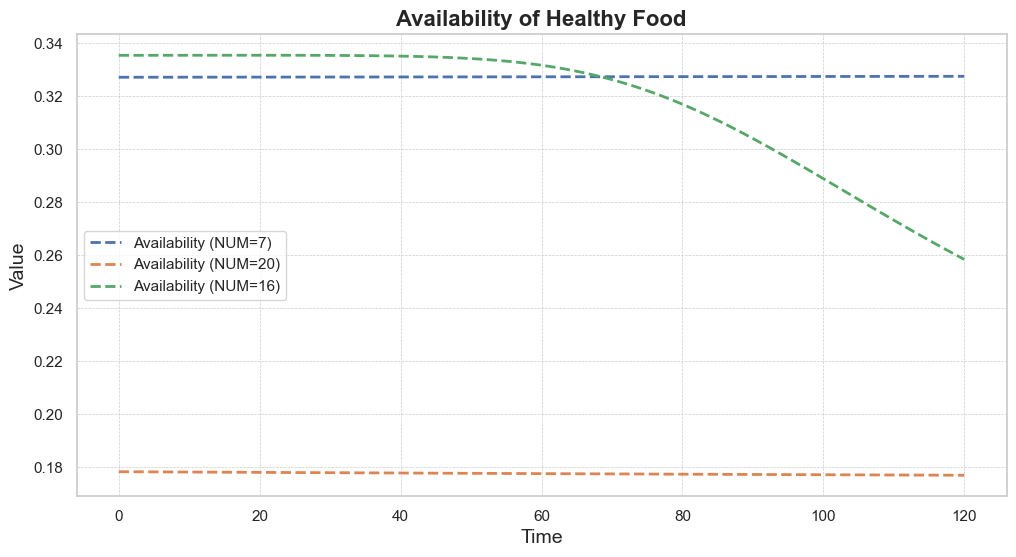

In [584]:
# Use seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Loop over each row in the DataFrame, where each row corresponds to a different NUM
for idx, row in df.iterrows():
    NUM_val = row['NUM']
    
    # Convert the JSON output for availability into a DataFrame and reset the index
    df_availability = pd.DataFrame.from_dict(
        pd.json_normalize(row['availabilityOfHealthyFoodInLocalArea']),
        orient='columns'
    ).T.reset_index(drop=True)
    
    # Plot the availability time series for this NUM.
    plt.plot(
        df_availability.index, 
        df_availability.values.flatten(), 
        label=f'Availability (NUM={NUM_val})',
        linestyle='--', 
        linewidth=2
    )

# Set x-axis ticks; adjust the step if needed.
plt.xticks(ticks=range(0, len(df_availability.index), 20))
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Availability of Healthy Food', fontsize=16, weight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a PNG file
plt.savefig('Figures/availability_only.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


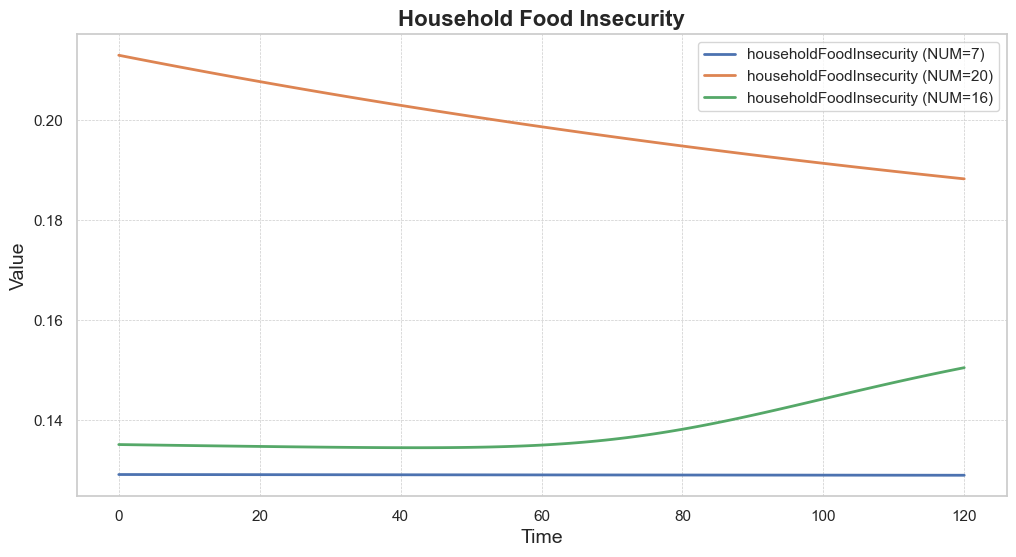

In [585]:
# Use seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Loop over each row in the DataFrame, where each row corresponds to a different NUM
for idx, row in df.iterrows():
    NUM_val = row['NUM']
    
    # Convert the JSON output for accessibility into a DataFrame and reset the index
    df_householdFoodInsecurity = pd.DataFrame.from_dict(
        pd.json_normalize(row['householdFoodInsecurity']), 
        orient='columns'
    ).T.reset_index(drop=True)
    
    # Plot the householdFoodInsecurity time series for this NUM.
    plt.plot(
        df_householdFoodInsecurity.index, 
        df_householdFoodInsecurity.values.flatten(), 
        label=f'householdFoodInsecurity (NUM={NUM_val})',
        linestyle='-', 
        linewidth=2
    )

# Set x-axis ticks; adjust the step if needed.
plt.xticks(ticks=range(0, len(df_accessibility.index), 20))
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Household Food Insecurity', fontsize=16, weight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a PNG file
plt.savefig('Figures/householdFoodInsecurity_only.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


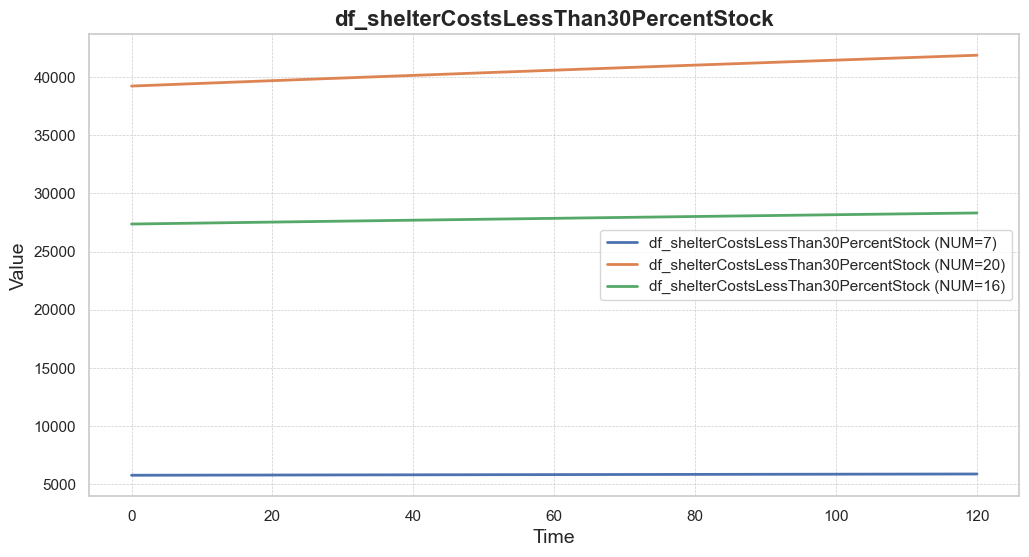

In [586]:
# Use seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Loop over each row in the DataFrame, where each row corresponds to a different NUM
for idx, row in df.iterrows():
    NUM_val = row['NUM']
    
    # Convert the JSON output for accessibility into a DataFrame and reset the index
    df_shelterCostsLessThan30PercentStock = pd.DataFrame.from_dict(
        pd.json_normalize(row['shelterCostsLessThan30PercentStock']), 
        orient='columns'
    ).T.reset_index(drop=True)
    
    # Plot the householdFoodInsecurity time series for this NUM.
    plt.plot(
        df_shelterCostsLessThan30PercentStock.index, 
        df_shelterCostsLessThan30PercentStock.values.flatten(), 
        label=f'df_shelterCostsLessThan30PercentStock (NUM={NUM_val})',
        linestyle='-', 
        linewidth=2
    )

# Set x-axis ticks; adjust the step if needed.
plt.xticks(ticks=range(0, len(df_accessibility.index), 20))
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('df_shelterCostsLessThan30PercentStock', fontsize=16, weight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a PNG file
plt.savefig('Figures/shelterCostsLessThan30Percent.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


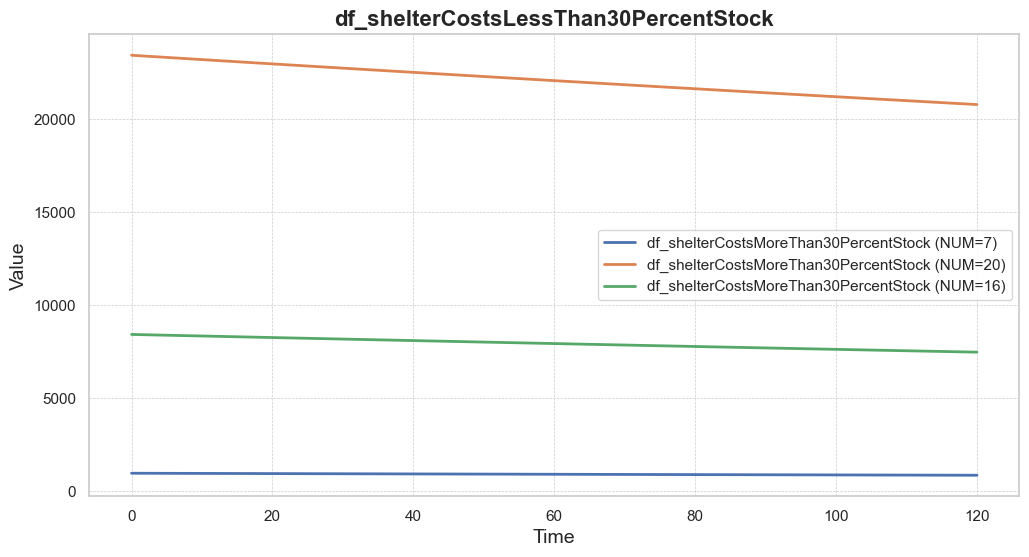

In [587]:
# Use seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Loop over each row in the DataFrame, where each row corresponds to a different NUM
for idx, row in df.iterrows():
    NUM_val = row['NUM']
    
    # Convert the JSON output for accessibility into a DataFrame and reset the index
    df_shelterCostsMoreThan30PercentStock = pd.DataFrame.from_dict(
        pd.json_normalize(row['shelterCostsMoreThan30PercentStock']), 
        orient='columns'
    ).T.reset_index(drop=True)
    
    # Plot the householdFoodInsecurity time series for this NUM.
    plt.plot(
        df_shelterCostsMoreThan30PercentStock.index, 
        df_shelterCostsMoreThan30PercentStock.values.flatten(), 
        label=f'df_shelterCostsMoreThan30PercentStock (NUM={NUM_val})',
        linestyle='-', 
        linewidth=2
    )

# Set x-axis ticks; adjust the step if needed.
plt.xticks(ticks=range(0, len(df_accessibility.index), 20))
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('df_shelterCostsLessThan30PercentStock', fontsize=16, weight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a PNG file
plt.savefig('Figures/shelterCostsMoreThan30Percent.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

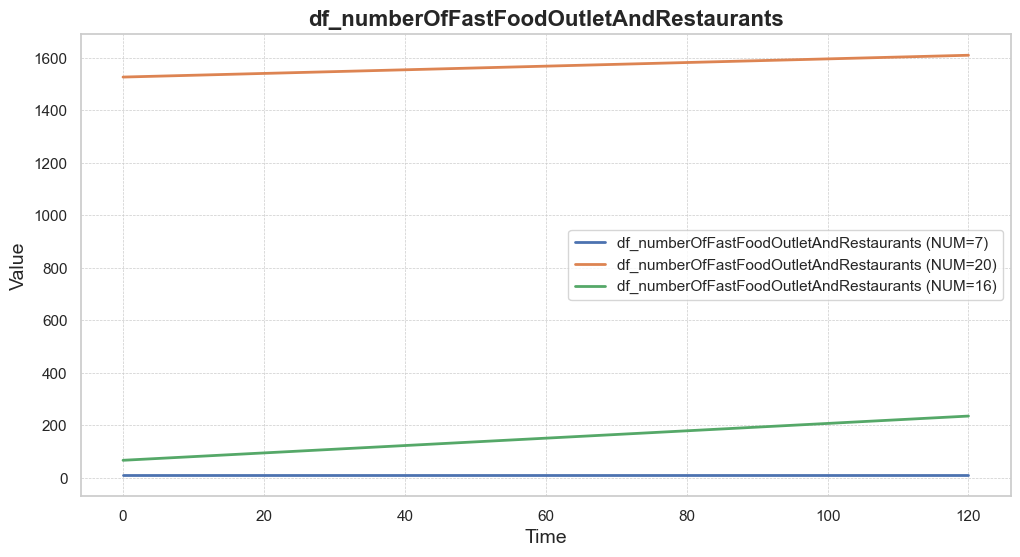

In [588]:
# Use seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Loop over each row in the DataFrame, where each row corresponds to a different NUM
for idx, row in df.iterrows():
    NUM_val = row['NUM']
    
    # Convert the JSON output for accessibility into a DataFrame and reset the index
    df_numberOfFastFoodOutletAndRestaurants = pd.DataFrame.from_dict(
        pd.json_normalize(row['numberOfFastFoodOutletAndRestaurants']), 
        orient='columns'
    ).T.reset_index(drop=True)
    
    # Plot the householdFoodInsecurity time series for this NUM.
    plt.plot(
        df_numberOfFastFoodOutletAndRestaurants.index, 
        df_numberOfFastFoodOutletAndRestaurants.values.flatten(), 
        label=f'df_numberOfFastFoodOutletAndRestaurants (NUM={NUM_val})',
        linestyle='-', 
        linewidth=2
    )

# Set x-axis ticks; adjust the step if needed.
plt.xticks(ticks=range(0, len(df_accessibility.index), 20))
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('df_numberOfFastFoodOutletAndRestaurants', fontsize=16, weight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a PNG file
plt.savefig('Figures/numberOfFastFoodOutletAndRestaurants.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()